In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot

12:38:12 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
color_control = '#4393c3'
color_stimulated = '#d6604d'

color_bs = '#5aae61'
color_ns = '#9970ab'

figsize_violin = (1.7, 3)
figsize_gen = (4, 3)

output_path = pathlib.Path("output") / "some-analysis"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [8]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))
units = pd.read_csv(identify_neurons.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [6]:
identify_neurons = actions['waveform-analysis']
waveform_results = pd.read_csv(identify_neurons.data_path('results'))

In [7]:
identify_neurons = actions['stimulus-response']
stimulus_results = pd.read_csv(identify_neurons.data_path('results'))

In [19]:
all_results = session_units.merge(
    waveform_results.merge(stimulus_results), how='left')

Text(0.5, 0.98, 'NS')

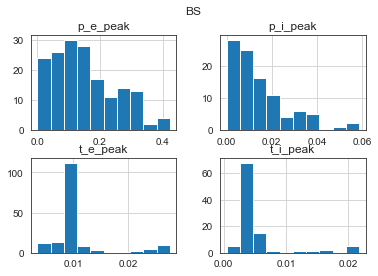

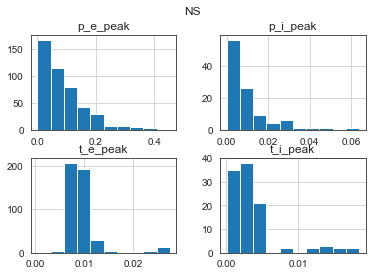

In [25]:
all_results.query('bs==0').loc[:,['t_i_peak', 't_e_peak', 'p_i_peak', 'p_e_peak']].hist()
plt.gcf().suptitle('BS')
all_results.query('bs==1').loc[:,['t_i_peak', 't_e_peak', 'p_i_peak', 'p_e_peak']].hist()
plt.gcf().suptitle('NS')

# Store results in Expipe action

In [144]:
action = project.require_action("some-analysis")

In [145]:
stuff = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in stuff.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [146]:
septum_mec.analysis.registration.store_notebook(action, "20_some_analysis.ipynb")